# Linear OLS regression with check for Gauss Markov conditions

In [1]:
import matplotlib.pyplot as plt
import math
from mlxtend.plotting import plot_decision_regions
import numpy as np
from numpy import percentile
from numpy.random import seed
import os
import pandas as pd
from sqlalchemy import create_engine
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import seaborn as sns
import sklearn.datasets
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.datasets import load_breast_cancer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df0 = pd.read_sql_query('select * from weatherinszeged', con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
nRow, nCol = df0.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 96453 rows and 12 columns


In [4]:
df0.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
# Help functions to gather basic descriptions
def describe(df):
    return pd.concat([df.describe().T,
                      df.mad().rename('mean abs dev'),
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt'),
                      df.nunique().rename('unique')
                     ], axis=1).T

In [6]:
# Non-numerical describe
df_stat = df0.describe(include = ['O']) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,summary,preciptype,dailysummary
count,96453,96453,96453
unique,27,3,214
top,Partly Cloudy,rain,Mostly cloudy throughout the day.
freq,31733,85224,20085
dtype,object,object,object
size,96453,96453,96453
% null,0,0,0


In [7]:
# Numerical describe
df_stat = df0.describe(include = [np.number]) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453,96453,96453,96453,96453,96453,96453,96453
mean,11.9327,10.855,0.734899,10.8106,187.509,10.3473,0,1003.24
std,9.55155,10.6968,0.195473,6.91357,107.383,4.19212,0,116.97
min,-21.8222,-27.7167,0,0,0,0,0,0
25%,4.68889,2.31111,0.6,5.8282,116,8.3398,0,1011.9
50%,12,12,0.78,9.9659,180,10.0464,0,1016.45
75%,18.8389,18.8389,0.89,14.1358,290,14.812,0,1021.09
max,39.9056,39.3444,1,63.8526,359,16.1,0,1046.38
dtype,float64,float64,float64,float64,float64,float64,float64,float64
size,96453,96453,96453,96453,96453,96453,96453,96453


## Check out columns with null values 

In [8]:
# Get a summary of null values in all the dataframe
print("No. of columns containing null values")
print(len(df0.columns[df0.isna().any()]))

print("No. of columns not containing null values")
print(len(df0.columns[df0.notna().all()]))

print("Total no. of columns in the dataframe")
print(len(df0.columns))

No. of columns containing null values
0
No. of columns not containing null values
12
Total no. of columns in the dataframe
12


In [9]:
# Get all columns with null values
nan_cols = [i for i in df0.columns if df0[i].isnull().any()]

In [12]:
# # Non-numerical describe
# df_stat = df0[nan_cols].describe(include = ['O']) 
# df_stat.loc['dtype'] = df0.dtypes
# df_stat.loc['size'] = len(df0)
# df_stat.loc['% null'] = df0.isnull().mean().round(2)
# df_stat

In [25]:
# # Drop columns with many missing values
df0 = df0.drop(['loudcover'], axis=1)

In [14]:
# # Get all columns with null values
# nan_cols = [i for i in df0.columns if df0[i].isnull().any()]

# # Numerical describe
# df_stat = df0[nan_cols].describe(include = [np.number]) 
# df_stat.loc['dtype'] = df0.dtypes
# df_stat.loc['size'] = len(df0)
# df_stat.loc['% null'] = df0.isnull().mean().round(2)
# df_stat

In [16]:
# # Fill NAs with mean 
# df0 = df0.fillna(df0.mean())

In [33]:
# Numerical describe
df_stat = df0.describe(include = [np.number]) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,pressure
count,96453,96453,96453,96453,96453,96453,96453
mean,11.9327,10.855,0.734899,10.8106,187.509,10.3473,1003.24
std,9.55155,10.6968,0.195473,6.91357,107.383,4.19212,116.97
min,-21.8222,-27.7167,0,0,0,0,0
25%,4.68889,2.31111,0.6,5.8282,116,8.3398,1011.9
50%,12,12,0.78,9.9659,180,10.0464,1016.45
75%,18.8389,18.8389,0.89,14.1358,290,14.812,1021.09
max,39.9056,39.3444,1,63.8526,359,16.1,1046.38
dtype,float64,float64,float64,float64,float64,float64,float64
size,96453,96453,96453,96453,96453,96453,96453


## Explore and fix any outliers

In [36]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df0_num = df0.select_dtypes(include=numerics)

In [37]:
df0_num.head(2)

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,pressure
0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13
1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63


(array([1, 2, 3, 4, 5, 6, 7]), <a list of 7 Text major ticklabel objects>)

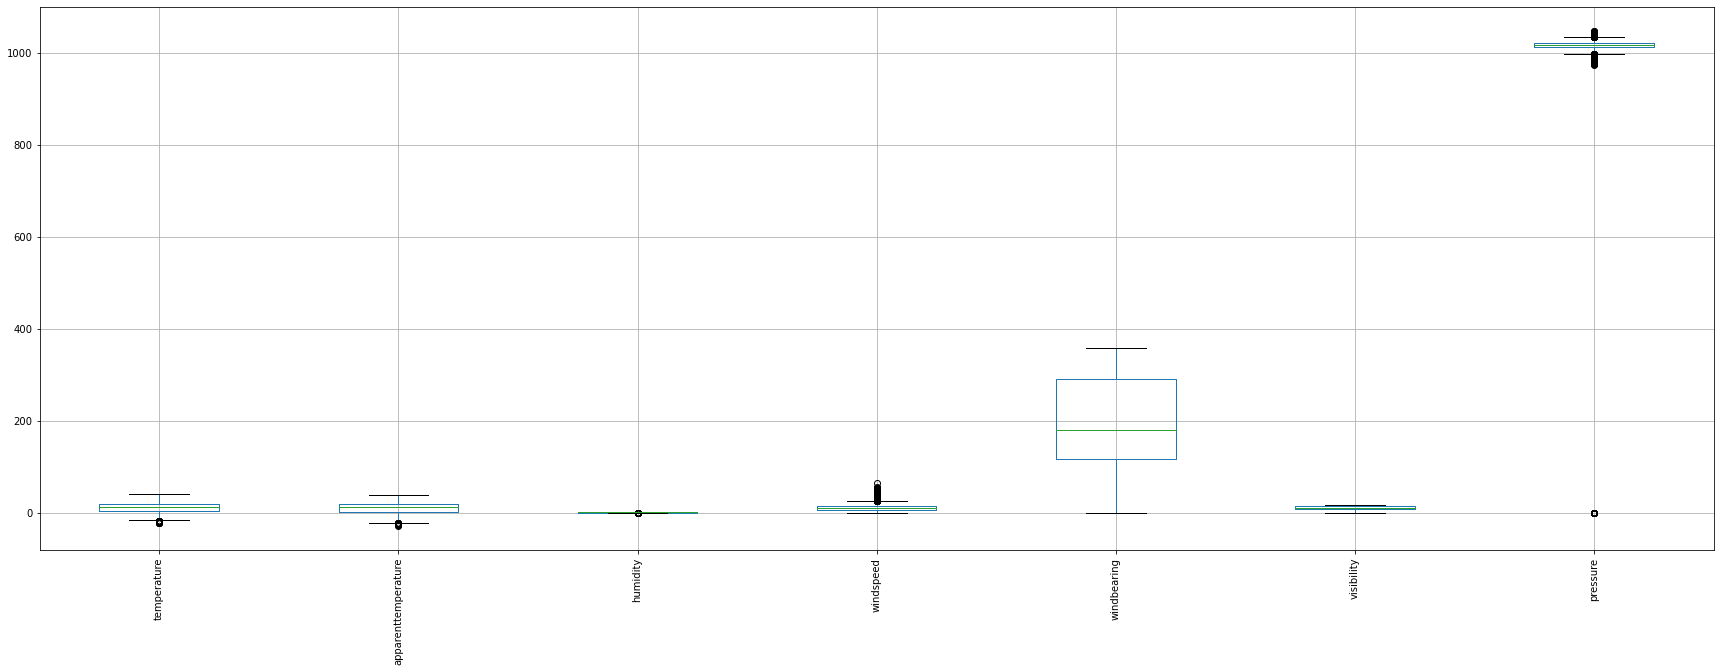

In [38]:
plt.figure(figsize = (30,10))
df0_num.boxplot()
plt.xticks(rotation=90)

In [39]:
col_dict = {c: i for i, c in enumerate(df0_num.columns, start=1)}

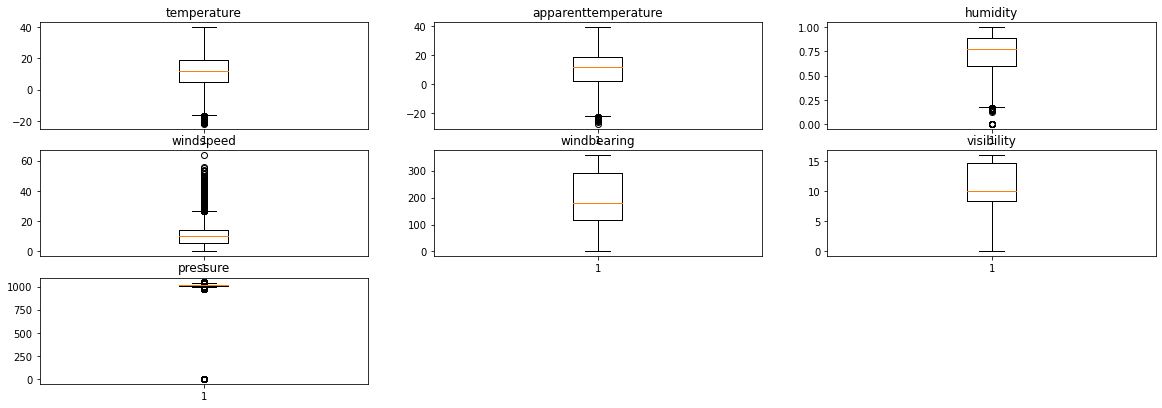

In [40]:
# Deleting outliers for each variable
# col_dict = {'Life_Expectancy':1,'Adult_Mortality':2,'Infant_Deaths':3,'Alcohol':4\
#             ,'Percentage_Exp':5,'HepatitisB':6,'Measles':7,'BMI':8,'Under_Five_Deaths':9,'Polio':10,'Tot_Exp':11\
#             ,'Diphtheria':12,'HIV/AIDS':13,'GDP':14,'Population':15,'Thinness_1to19_Years':16\
#             ,'Thinness_5to9_Years':17,'Income_Comp_of_Resources':18,'Schooling':19}


# Detect outliers in each variable using box plots.
plt.figure(figsize=(20,70))

for variable,i in col_dict.items():
                     plt.subplot(30,3,i)
                     plt.boxplot(df0[variable],whis=1.5)
                     plt.title(variable)
plt.show()

In [42]:
# Calculate number of outliers and its percentage in each variable using Tukey's method.
for variable in col_dict.keys():
    q75, q25 = np.percentile(df0[variable], [75 ,25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    col_length = len(np.where(df0[variable])[0])
    print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
                                                len((np.where((df0[variable] > max_val) | (df0[variable] < min_val))[0])),
                                                len((np.where((df0[variable] > max_val) | (df0[variable] < min_val))[0]))*100/col_length))

Number of outliers and percentage of it in temperature : 44 and 0.04577230359520639
Number of outliers and percentage of it in apparenttemperature : 22 and 0.022825365205843294
Number of outliers and percentage of it in humidity : 46 and 0.0477025023073493
Number of outliers and percentage of it in windspeed : 3020 and 3.173735760225314
Number of outliers and percentage of it in windbearing : 0 and 0.0
Number of outliers and percentage of it in visibility : 0 and 0.0
Number of outliers and percentage of it in pressure : 4400 and 4.623548573530185


## Winsorize outliers 

In [43]:
def using_mstats(s):
    return winsorize(s, limits=[0.01, 0.01])

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df0_num = df0.select_dtypes(include=numerics)
num_cols = df0_num.columns

df0[num_cols] = df0[num_cols].apply(lambda x: winsorize(x, limits=[0.01, 0.01]))

(array([1, 2, 3, 4, 5, 6, 7]), <a list of 7 Text major ticklabel objects>)

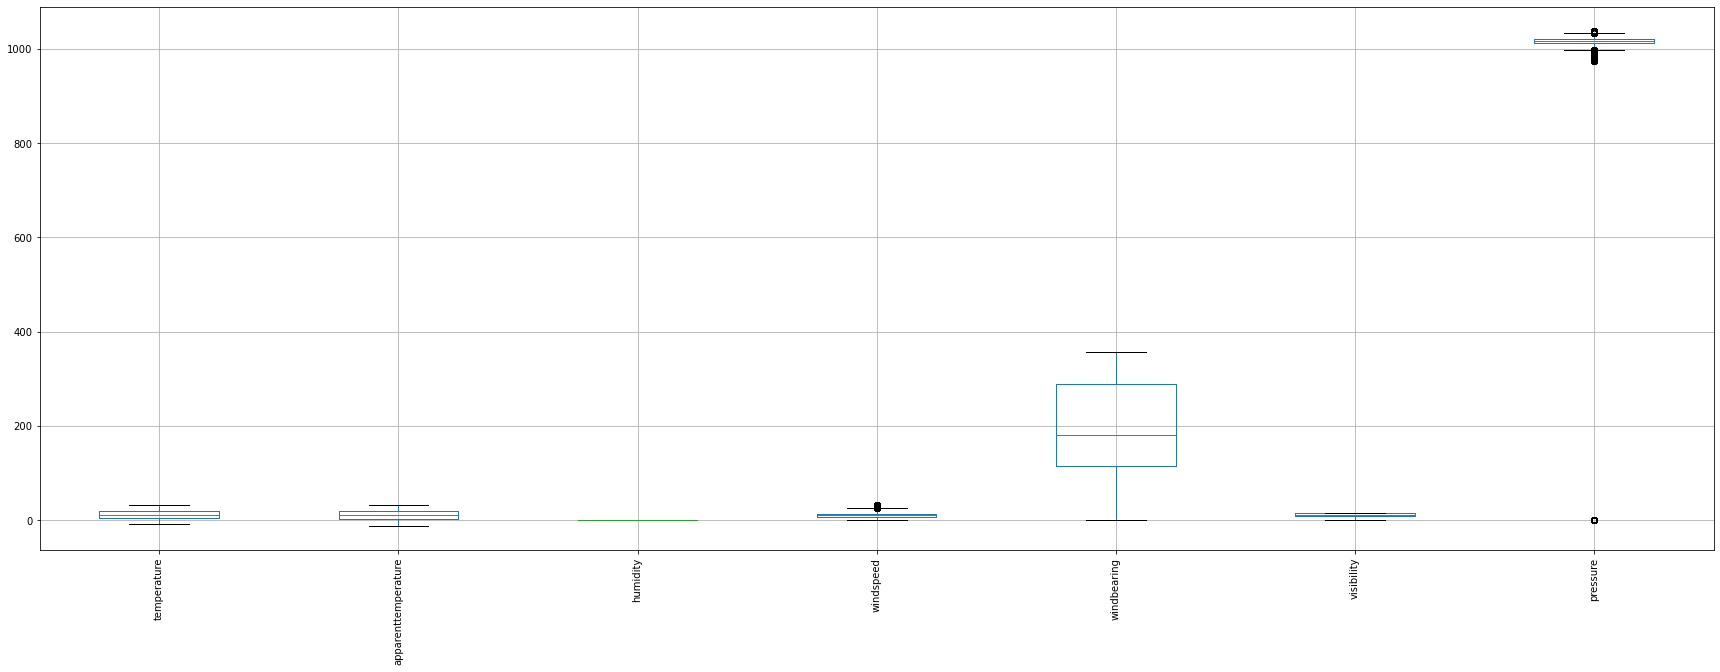

In [48]:
plt.figure(figsize = (30,10))
df0.boxplot()
plt.xticks(rotation=90)

## Add dummy variables for some categorical data 

In [45]:
df0.columns

Index(['date', 'summary', 'preciptype', 'temperature', 'apparenttemperature',
       'humidity', 'windspeed', 'windbearing', 'visibility', 'pressure',
       'dailysummary'],
      dtype='object')

In [46]:
df0.head(2)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.


In [49]:
# Y is the target variable
Y = df0['temperature']
# X is the feature set which includes
X = df0[['humidity', 'windspeed', 'windbearing', 'pressure']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24830108e+01 -2.06513182e-01  3.93344875e-03 -6.44880277e-04]

Intercept: 
 37.960102545987944


## Check for linearity assumption

### The way we have specified our model here supports the linearity assumption

## Check assumption that error term should be zero on average¶

In [51]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -1.9990345222632865e-15


### Since we have a constant term in the model, the average of the model's error is effectively zero.

## Check for the homoscedasticity assumption

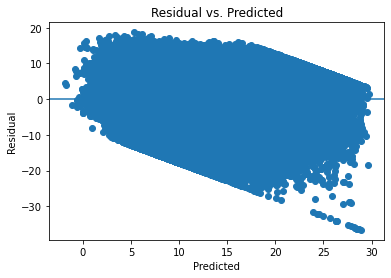

In [52]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### We can see that our error terms are not consistently distributed. We have more variance in the error for the large outcome values than for small ones. Because of this the confidence interval for large predicted values will be too small because it will be based on the average error variace.

### Perform Barlett and Levne tests

In [53]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2195.8 and p value is 0
Levene test statistic value is 2286.82 and p value is 0


### The p-values of both tests are less than 0.05, meaning we can reject the null hypothesis which means our errors are hetetroscedastic.

## Check for low multicollinearity

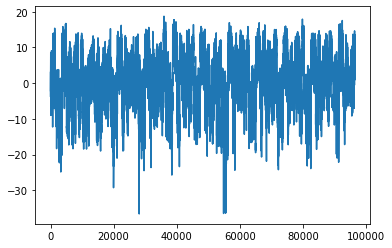

In [54]:
plt.plot(errors)
plt.show()

### It seems that the error terms of our model are uncorrelated with each other.

### Another option is to check the autocorrelation function. 

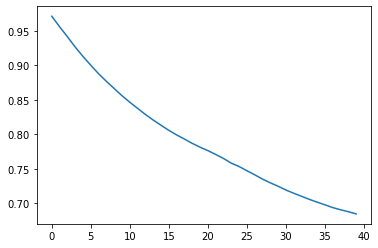

In [55]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

### We have high multicollinearity violating the OLS assumptions

## Check if the features are correlated with the errors. 

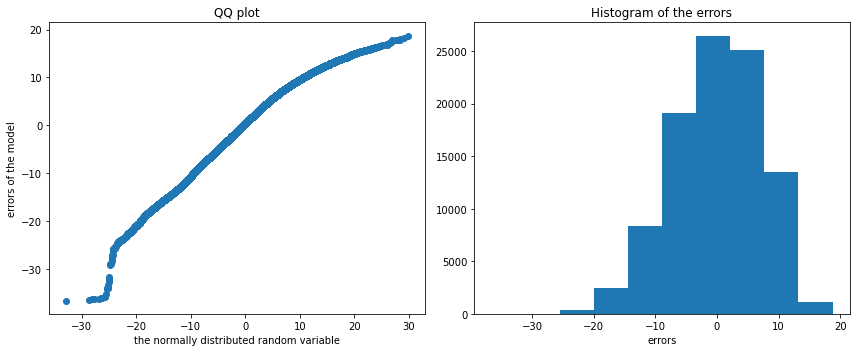

In [56]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

### bove shows that our wrros are not normally distributed exactly and not far away.

### Perform Jargue Berra and normals tests

In [57]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [58]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 2212.4687128014366 and p value is 0.0
Normality test statistics is 2167.3169763863825 and p value is 0.0


### The p-values of both tests indicate that our errors are not normally distributed.

### We run the same model and this time using statsmodels.

In [59]:
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                 1.782e+04
Date:                Wed, 12 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:07:30   Log-Likelihood:            -3.2674e+05
No. Observations:               96453   AIC:                         6.535e+05
Df Residuals:                   96448   BIC:                         6.535e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9601      0.230    165.029      0.000      37.509      38.411
humidity      -32.4830      0.122   -266.702      0.000     -32.722     -32.244
windspeed      -0.2065      0.004    -58.570      0.000      -0.213      -0.200
windbearing     0.0039      0.000     18.211      0.000       0.004       0.004
pressure       -0.0006      0.000     -3.267      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     2167.317   Durbin-Watson:                   0.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2212.469
Skew:                          -0.352   Prob(JB):                         0.00
Kurtosis:                       2.763   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""